### Preprocessing Data

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
from itertools import islice
import numpy as np

filename_infrastructure = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
filename_boundaries = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'

In [2]:
infrastructure = pd.read_csv(filename_infrastructure)
infrastructure = gpd.GeoDataFrame(infrastructure)
infrastructure['the_geom'] = infrastructure['the_geom'].apply(shapely.wkt.loads)
infrastructure.set_geometry('the_geom', inplace=True)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_50798/3234150003.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  infrastructure = pd.read_csv(filename_infrastructure)


In [3]:
filter = gpd.read_file(filename_boundaries)
filter = filter[filter['boro_name'] == 'Manhattan']

<AxesSubplot:>

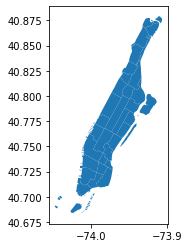

In [4]:
filter.plot()

In [5]:
infrastructure_restricted = infrastructure.sjoin(filter) # restrict streets to filter
if 'index_right' in infrastructure.columns:
    infrastructure_restricted.drop(columns=['index_right'], inplace=True)

infrastructure_restricted.drop_duplicates(subset=['PHYSICALID'], keep='first', inplace=True) # remove duplicates from join

infrastructure_bike = infrastructure_restricted[infrastructure_restricted['BIKE_LANE'].notna()] # subset to bicycle network

infrastructure_bike['segment_ID'] = infrastructure_bike.index # add ID column

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

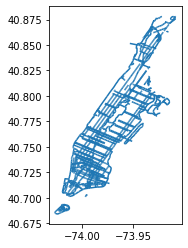

In [6]:
infrastructure_bike.plot()

In [7]:
def get_neighbors(geometry, id):
    neighbors = infrastructure_bike['segment_ID'].loc[infrastructure_bike['the_geom'].intersects(geometry)].tolist()
    neighbors.remove(id)
    return neighbors

# Build column with adjacent segments
infrastructure_bike['neighbors'] = infrastructure_bike.apply(lambda x: get_neighbors(x.the_geom, x.segment_ID), axis=1)

# Additional constraints like which way to turn, which roads meet at intersection

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_50798/1014587558.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename_collisions).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])


In [9]:
markers = ['bike', 'bicyc', 'e - b', 'e-bik', 'e-unicycle', 'bk']
mask = collisions['VEHICLE TYPE CODE 1'].str.contains('bike') # placeholder
for i in [1,2,3,4,5]:
    for marker in markers:
        mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains(marker, case=False)

# Restrict to collisions involving bikes
collisions = collisions.loc[mask]

In [10]:
collisions = collisions[collisions.LONGITUDE != 0] # remove 0,0 coordinates
collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

collisions_restricted = collisions.sjoin(filter)
if 'index_right' in collisions_restricted.columns:
    collisions_restricted.drop(columns=['index_right'], inplace=True)

collisions_restricted['collision_ID'] = collisions_restricted.index # add ID column

/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [11]:
collisions_connected = collisions_restricted.sjoin_nearest(infrastructure, max_distance=0.0001, how='inner')
if 'index_right' in collisions_connected.columns:
    collisions_connected.drop(columns=['index_right'], inplace=True)
if 'index_left' in collisions_connected.columns:
    collisions_connected.drop(columns=['index_left'], inplace=True)

collisions_connected.drop_duplicates(subset=['collision_ID'], keep='first', inplace=True)

In [12]:
collisions_connected['CRASH DATE'] = pd.to_datetime(collisions_connected['CRASH DATE'])
collisions_connected.groupby([collisions_connected['CRASH DATE'].dt.year]).count()
## Let's start in 2016 since previous years of citibike have far fewer rides

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SHAPE_Leng
CRASH DATE,,,,,,,,,,,,,,,,,,,,,
2012,800,800,795,795,800,800,800,792,792,3,...,0,363,36,717,19,7,800,800,342,800
2013,1654,1654,1652,1652,1654,1654,1654,1644,1644,8,...,0,761,74,1513,36,7,1654,1654,716,1654
2014,1687,1687,1686,1686,1687,1687,1687,1680,1680,6,...,0,761,71,1532,31,7,1687,1687,723,1687
2015,1733,1733,1726,1726,1733,1733,1733,1716,1716,13,...,0,795,68,1587,31,9,1733,1733,740,1733
2016,1900,1900,1480,1480,1900,1900,1900,1471,1146,428,...,0,936,73,1736,51,26,1900,1900,779,1900
2017,2005,2005,1420,1420,2005,2005,2005,1504,972,501,...,0,999,65,1847,37,8,2005,2005,845,2005
2018,2002,2002,1478,1478,2002,2002,2002,1551,1061,451,...,0,1047,57,1857,41,6,2002,2002,812,2002
2019,2085,2085,1503,1503,2085,2085,2085,1609,1064,476,...,0,1073,67,1931,37,11,2085,2085,850,2085
2020,1630,1630,1133,1133,1630,1630,1630,1303,839,327,...,0,910,24,1547,33,5,1630,1630,580,1630


In [13]:

start_date = pd.Timestamp('2016-01-01')
collisions_recent = collisions_connected.loc[collisions_connected['CRASH DATE'] >= start_date]

In [14]:
year = '2016'
month = '01'
filename_citibike = f'data_unwrangled/citibike/{year}{month}-citibike-tripdata.csv'
citibike_yearmonth = pd.read_csv(filename_citibike)

In [15]:
citibike_yearmonth = gpd.GeoDataFrame(citibike_yearmonth)
citibike_yearmonth['start_geom'] = gpd.points_from_xy(citibike_yearmonth['start station longitude'], citibike_yearmonth['start station latitude'])
citibike_yearmonth['end_geom'] = gpd.points_from_xy(citibike_yearmonth['end station longitude'], citibike_yearmonth['end station latitude'])

In [16]:
for geom in ['start_geom', 'end_geom']:
    citibike_yearmonth.set_geometry(geom, inplace=True)
    citibike_yearmonth = citibike_yearmonth.sjoin(filter)
    if 'index_right' in citibike_yearmonth.columns:
        citibike_yearmonth.drop(columns=['index_right'], inplace=True)


/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [17]:
citibike_yearmonth['starttime'] = pd.to_datetime(citibike_yearmonth['starttime'])
citibike_yearmonth['starttime_rounded'] = citibike_yearmonth['starttime'].dt.floor('d')

citibike_yearmonth = citibike_yearmonth[citibike_yearmonth['tripduration'] <= 24 * 60 * 60]

In [70]:
if 'index_right' in infrastructure_bike.columns:
    infrastructure_bike = infrastructure_bike.drop(columns=['index_right'])

stations = {'start': {}, 'end': {}}
for type in ['start', 'end']:
    renaming = {f'{type} station id': 'station_id', f'{type} station name': 'station_name', f'{type}_geom': 'geometry', f'{type} station latitude': 'latitude', f'{type} station longitude': 'longitude'}
    stations[type] = citibike_yearmonth.drop_duplicates(subset=[f'{type} station id'], keep='first').rename(columns=renaming)
    stations[type] = stations[type][renaming.values()]
stations = pd.concat([stations['start'], stations['end']])

stations = stations.drop_duplicates(subset=['station_id'], keep='first')
stations = stations.set_geometry('geometry')
stations = stations.sjoin_nearest(infrastructure_bike, max_distance=0.01, how='left')
if 'index_right' in stations.columns:
    stations.drop(columns=['index_right'], inplace=True)
stations = stations.drop_duplicates(subset=[f'station_id'], keep='first')

In [78]:
collisions_connected = collisions_restricted.sjoin_nearest(infrastructure_bike, max_distance=0.01, how='left')
if 'index_right' in collisions_connected.columns:
    collisions_connected.drop(columns=['index_right'], inplace=True)

In [93]:
graph = nx.from_pandas_edgelist(infrastructure_bike.explode('neighbors'), source='segment_ID', target='neighbors')

In [94]:
length = len(nx.shortest_path(graph, 82, 103442))
print(length)

15


In [129]:
paths = {}
for source in stations['segment_ID']:
    pred = nx.predecessor(graph, source)
    for target in stations['segment_ID']:
        if source < target:
            paths[(source, target)]= list(nx.algorithms.shortest_paths.generic._build_paths_from_predecessors([source], target, pred))

In [131]:
print(len(paths))